# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of industrial crop production in Italy 2006-2022
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).



In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
industrial_crop = pd.read_csv('./Italy_crop_data/industrial_crop.csv',skipinitialspace=True)
industrial_crop.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2006,2006,750,e,estimate data
1,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2007,2007,780,NaN,NaN
2,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2008,2008,810,NaN,NaN
3,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2009,2009,773,e,estimate data
4,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2010,2010,788,e,estimate data


## Pre-processing dataset 

In [3]:
# Drop Columns
industrial_crop = industrial_crop.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
industrial_crop

,Territory,Data type,Type of crop,Select time,Value
0,Cuneo,total production - quintals,parsley in greenhouses,2006,750
1,Cuneo,total production - quintals,parsley in greenhouses,2007,780
2,Cuneo,total production - quintals,parsley in greenhouses,2008,810
3,Cuneo,total production - quintals,parsley in greenhouses,2009,773
4,Cuneo,total production - quintals,parsley in greenhouses,2010,788
...,...,...,...,...,...
19180,Trentino Alto Adige / Südtirol,harvested production - quintals,hops,2021,60
19181,Grosseto,total area - hectares,other oilseed crops (excluding sesame),2021,72
19182,Udine,total area - hectares,hops,2021,1
19183,Arezzo,total area - hectares,other textile crops,2021,4


In [4]:
# Rename Columns
industrial_crop = industrial_crop.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(industrial_crop):
    print('DATASET SHAPE: ', industrial_crop.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(industrial_crop.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(industrial_crop.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(industrial_crop.isnull().sum())
show_info(industrial_crop)

DATASET SHAPE:  (19185, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19185 entries, 0 to 19184
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       19185 non-null  object
 1   Data_type  19185 non-null  object
 2   Type_crop  19185 non-null  object
 3   Year       19185 non-null  int64 
 4   Value      19185 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 749.5+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          108
Data_type       4
Type_crop      18
Year           17
Value        4025
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing industrial crop

In [6]:
#industrial_crop.City.unique()


In [7]:
industrial_crop.Data_type.unique()

array(['total production - quintals ', 'harvested production - quintals ',
       'total area - ares', 'total area - hectares'], dtype=object)

## Select only Values for total industrial crop production - quintals


In [8]:
industrial_crop_prod = industrial_crop[industrial_crop['Data_type'] == 'total production - quintals ']
industrial_crop_prod.head()

,City,Data_type,Type_crop,Year,Value
0,Cuneo,total production - quintals,parsley in greenhouses,2006,750
1,Cuneo,total production - quintals,parsley in greenhouses,2007,780
2,Cuneo,total production - quintals,parsley in greenhouses,2008,810
3,Cuneo,total production - quintals,parsley in greenhouses,2009,773
4,Cuneo,total production - quintals,parsley in greenhouses,2010,788


In [9]:
industrial_crop_prod['Value'] = industrial_crop_prod['Value']/10
industrial_crop_prod

,City,Data_type,Type_crop,Year,Value
0,Cuneo,total production - quintals,parsley in greenhouses,2006,75.0
1,Cuneo,total production - quintals,parsley in greenhouses,2007,78.0
2,Cuneo,total production - quintals,parsley in greenhouses,2008,81.0
3,Cuneo,total production - quintals,parsley in greenhouses,2009,77.3
4,Cuneo,total production - quintals,parsley in greenhouses,2010,78.8
...,...,...,...,...,...
19137,Campobasso,total production - quintals,"other aromatic, medicinal and culinary plants",2021,15.0
19143,Reggio di Calabria,total production - quintals,"other aromatic, medicinal and culinary plants",2021,9.5
19144,Caserta,total production - quintals,"other aromatic, medicinal and culinary plants",2021,3352.0
19177,Trentino Alto Adige / Südtirol,total production - quintals,hops,2020,5.0


In [10]:
industrial_crop_prod = industrial_crop_prod.rename(columns = {'Value':'Total_production'})
industrial_crop_prod

,City,Data_type,Type_crop,Year,Total_production
0,Cuneo,total production - quintals,parsley in greenhouses,2006,75.0
1,Cuneo,total production - quintals,parsley in greenhouses,2007,78.0
2,Cuneo,total production - quintals,parsley in greenhouses,2008,81.0
3,Cuneo,total production - quintals,parsley in greenhouses,2009,77.3
4,Cuneo,total production - quintals,parsley in greenhouses,2010,78.8
...,...,...,...,...,...
19137,Campobasso,total production - quintals,"other aromatic, medicinal and culinary plants",2021,15.0
19143,Reggio di Calabria,total production - quintals,"other aromatic, medicinal and culinary plants",2021,9.5
19144,Caserta,total production - quintals,"other aromatic, medicinal and culinary plants",2021,3352.0
19177,Trentino Alto Adige / Südtirol,total production - quintals,hops,2020,5.0


In [11]:
industrial_crop_prod = industrial_crop_prod.drop(columns =['Data_type'])
industrial_crop_prod

,City,Type_crop,Year,Total_production
0,Cuneo,parsley in greenhouses,2006,75.0
1,Cuneo,parsley in greenhouses,2007,78.0
2,Cuneo,parsley in greenhouses,2008,81.0
3,Cuneo,parsley in greenhouses,2009,77.3
4,Cuneo,parsley in greenhouses,2010,78.8
...,...,...,...,...
19137,Campobasso,"other aromatic, medicinal and culinary plants",2021,15.0
19143,Reggio di Calabria,"other aromatic, medicinal and culinary plants",2021,9.5
19144,Caserta,"other aromatic, medicinal and culinary plants",2021,3352.0
19177,Trentino Alto Adige / Südtirol,hops,2020,5.0


## Total industrial crop production in 2006-2022

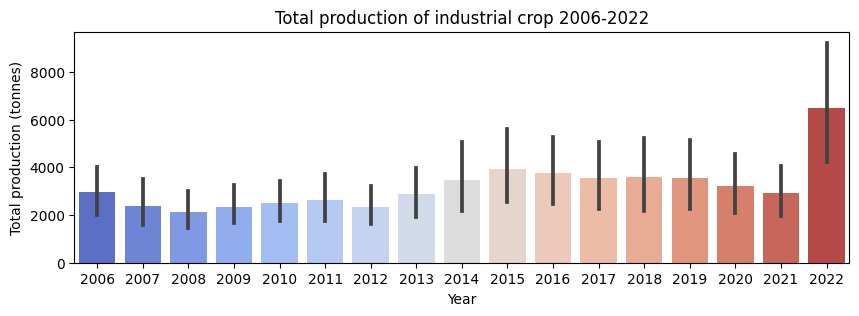

In [12]:
plt.figure(figsize= (10,3))
sns.barplot(x= 'Year', y= 'Total_production',data = industrial_crop_prod, palette='coolwarm')
plt.title('Total production of industrial crop 2006-2022')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes)')
plt.show()



## Industrial crop production by Cities 

In [13]:
industrial_crop_prod_region = industrial_crop_prod.groupby(by = industrial_crop_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False)
industrial_crop_prod_region



,City,Total_production
101,Venezia,2050509.3
98,Udine,1518676.9
83,Rovigo,1401013.8
31,Ferrara,1246983.0
63,Padova,1105870.4
...,...,...
42,La Spezia,44.7
60,Ogliastra,28.3
61,Olbia-Tempio,10.9
29,Enna,9.4


In [14]:
region = industrial_crop_prod_region.nlargest(20, 'Total_production')

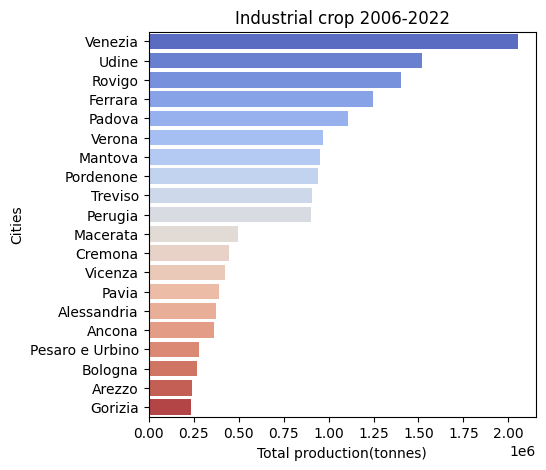

In [15]:
plt.figure(figsize= (5,5))
sns.barplot(x= region['Total_production'],y= region['City'], orient='h', palette='coolwarm');
plt.title('Industrial crop 2006-2022')
plt.xlabel('Total production(tonnes)')
plt.ylabel('Cities')
plt.show() 

##  Industrial crop  2006-2022

In [16]:
print(industrial_crop_prod.Type_crop.max())
print(industrial_crop_prod.Type_crop.value_counts())
print(industrial_crop_prod.Type_crop.nunique())



valerian in greenhouses
sunflower                                        1204
rape                                             1023
soya beans                                        986
sweet basil in greenhouses                        654
parsley in open field                             624
parsley in greenhouses                            585
tobacco                                           352
valerian in greenhouses                           327
hemp                                              320
flax                                              127
turnip rape                                        77
groundnut                                          51
hops                                               33
sesame                                              8
other aromatic, medicinal and culinary plants       8
cotton                                              5
other textile crops                                 2
other oilseed crops (excluding sesame)              1
Name

Dataset shows there are 17 different types of industrial crop cultivated in Italy. The top most produced crops are : Valerian, Greenhouses, Sunflower, Rape, Soya beans, Hemp, Parsley in open field, Sweet basil in greenhouses, Parsley in greenhouses, Tobacco, Flax. 


In [17]:
industrial_crop_prod.describe()

,Year,Total_production
count,6387.000000,6387.000000
mean,2014.166902,3153.793424
std,4.763694,12418.126771
min,2006.000000,0.000000
25%,2010.000000,24.000000
50%,2014.000000,150.000000
75%,2018.000000,930.000000
max,2022.000000,173978.000000


In [18]:
industrial_crop_prod = industrial_crop_prod.replace('valerian in greenhouses','valerian-ghouse')
industrial_crop_prod = industrial_crop_prod.replace('sweet basil in greenhouses','basil-ghouse')
industrial_crop_prod = industrial_crop_prod.replace('other aromatic, medicinal and culinary plants','aromatic-medicinal')
industrial_crop_prod = industrial_crop_prod.replace('parsley in greenhouses','parsley-ghouse')
industrial_crop_prod = industrial_crop_prod.replace('parsley in open field','parsley-field')
industrial_crop_prod = industrial_crop_prod.replace('other oilseed crops (excluding sesame)','oilseeds(No-sesame)')
industrial_crop_prod = industrial_crop_prod.replace('other textile crops','textile-crops')

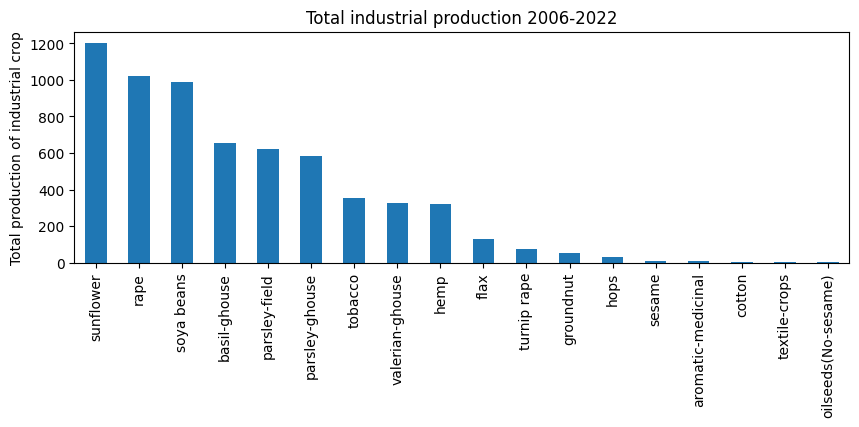

In [19]:
plt.figure(figsize=(10,3))
industrial_crop_prod ['Type_crop'].value_counts().plot.bar()
plt.title('Total industrial production 2006-2022')
plt.ylabel('Total production of industrial crop')
plt.show()


## Subseting data

In [20]:
industrial_crop_top10 = industrial_crop_prod.apply(lambda row: row[industrial_crop_prod['Type_crop'].isin(['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                                                                                                           'soya beans', 'hemp', 'parsley-field', 
                                                                                                           'parsley-ghouse', 'tobacco', 'flax'])])

industrial_crop_top10.head()

,City,Type_crop,Year,Total_production
0,Cuneo,parsley-ghouse,2006,75.0
1,Cuneo,parsley-ghouse,2007,78.0
2,Cuneo,parsley-ghouse,2008,81.0
3,Cuneo,parsley-ghouse,2009,77.3
4,Cuneo,parsley-ghouse,2010,78.8


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'parsley-ghouse'),
  Text(1, 0, 'soya beans'),
  Text(2, 0, 'basil-ghouse'),
  Text(3, 0, 'sunflower'),
  Text(4, 0, 'parsley-field'),
  Text(5, 0, 'hemp'),
  Text(6, 0, 'rape'),
  Text(7, 0, 'flax'),
  Text(8, 0, 'valerian-ghouse'),
  Text(9, 0, 'tobacco')])

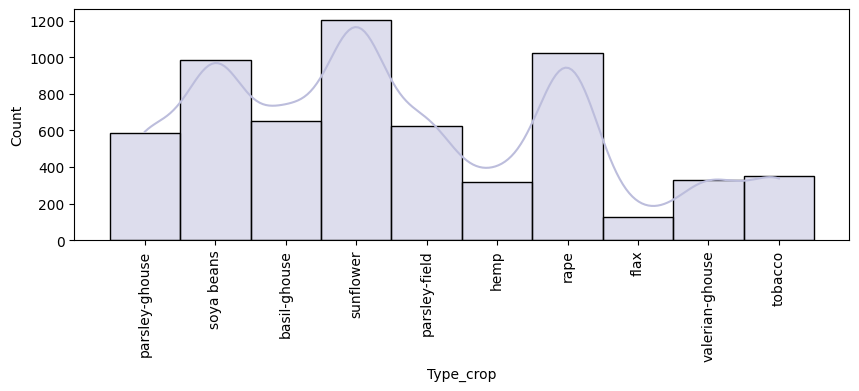

In [21]:
plt.figure(figsize=(10,3))
sns.histplot(industrial_crop_top10, x="Type_crop", kde=True, color='#bcbddc')
plt.xticks(rotation = 90)

### Calculate and print the interquartile range

The data need to be normalized for further use in a modelling. Here the data will be normalize by deleting outliers using the interquartile range (IQR).

Calculate and print the interquartile range

In [22]:
Q1 = industrial_crop_top10.quantile(0.25)
Q3 = industrial_crop_top10.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


Year                  8.00
Total_production    971.55
dtype: float64


### Remove outliers and plot graphs

In [23]:
# Remove outliers
industrial_crop_top10 = industrial_crop_top10[~((industrial_crop < (Q1 - 1.5 * IQR)) | (industrial_crop_top10 > (Q3 + 1.5 * IQR))).any(axis=1)]
print(industrial_crop_top10.shape)

(5188, 4)


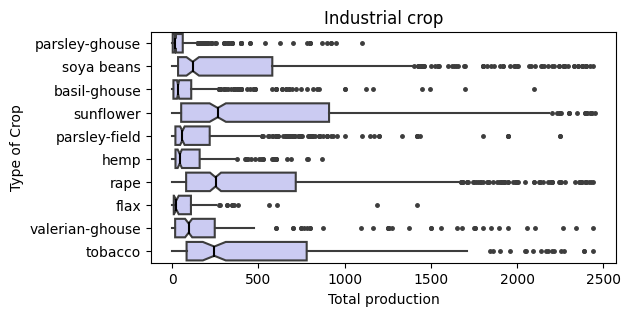

In [24]:
plt.figure(figsize=(6,3))

sns.boxplot(
    data=industrial_crop_top10, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.6, .6, .9, .5)},
    medianprops={"color": "black"},
)
plt.title('Industrial crop')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

(0.0, 3194.3064423715455)

<Figure size 500x300 with 0 Axes>

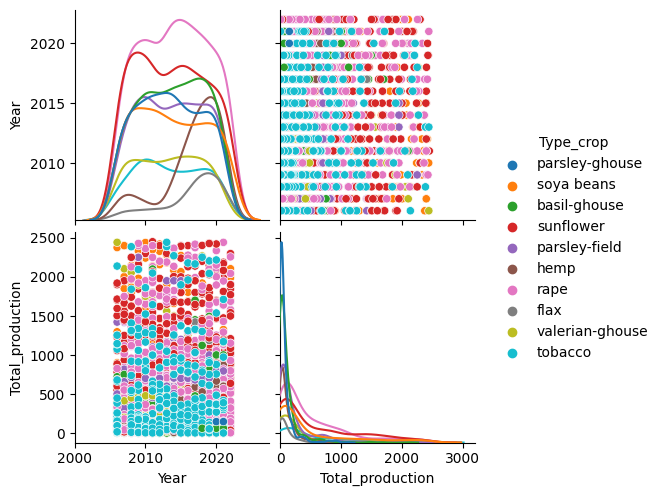

In [25]:
plt.figure(figsize=(5,3))
sns.pairplot(industrial_crop_top10, hue="Type_crop", diag_kws=dict(fill=False))
plt.xlim(0, None)

In [26]:
industrial_crop_top10.describe().astype(int)

,Year,Total_production
count,5188,5188
mean,2013,323
std,4,509
min,2006,0
25%,2010,19
50%,2014,97
75%,2018,370
max,2022,2450


## Vizualization of ten type of industrial crop produced in Italy in the period of 2006-2022 

In [27]:
# Select year 2020 for future join with fertilizer
industrial_crop_top10 = industrial_crop_top10[industrial_crop_top10['Year'] < 2021]
industrial_crop_top10



,City,Type_crop,Year,Total_production
0,Cuneo,parsley-ghouse,2006,75.0
1,Cuneo,parsley-ghouse,2007,78.0
2,Cuneo,parsley-ghouse,2008,81.0
3,Cuneo,parsley-ghouse,2009,77.3
4,Cuneo,parsley-ghouse,2010,78.8
...,...,...,...,...
19033,Sud Sardegna,basil-ghouse,2019,60.6
19034,Sud Sardegna,basil-ghouse,2020,60.6
19044,La Spezia,tobacco,2019,44.7
19045,Gorizia,tobacco,2019,53.7


<Figure size 500x300 with 0 Axes>

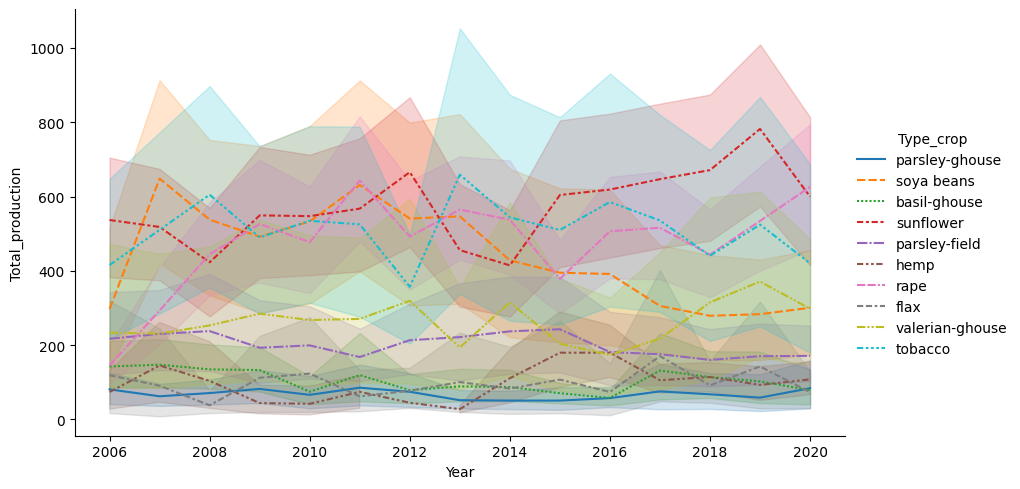

In [28]:
#Crop harvested by year
plt.figure(figsize=(5,3))
plotcrop10 = sns.relplot(kind='line', data=industrial_crop_top10, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


In [29]:
industrial_crop_top10.describe()

,Year,Total_production
count,4730.000000,4730.000000
mean,2013.269345,320.070381
std,4.305397,507.107053
min,2006.000000,0.100000
25%,2010.000000,19.500000
50%,2013.000000,96.350000
75%,2017.000000,360.000000
max,2020.000000,2450.000000


### Create columns for each type crop 

In [30]:
# Create columns for each type crop
industrial_crop_top10_pivot = industrial_crop_top10.pivot_table(index=[ 'City','Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
industrial_crop_top10_pivot

Total_production                                            \
Type_crop          basil-ghouse   flax  hemp parsley-field parsley-ghouse   
City      Year                                                              
Agrigento 2006              NaN    NaN   NaN           5.0            NaN   
          2007              NaN    NaN   NaN           9.0            NaN   
          2008              NaN    NaN   NaN           8.8            NaN   
          2009              NaN    NaN   NaN           8.4            NaN   
          2010              NaN    NaN   NaN           9.7            NaN   
...                         ...    ...   ...           ...            ...   
Viterbo   2016              NaN    NaN   NaN           NaN            NaN   
          2017              NaN    NaN   NaN           NaN            NaN   
          2018              NaN  100.0  48.0           NaN            NaN   
          2019              NaN  115.0  16.5           NaN            NaN   
          2020              NaN  115.0  21.5           NaN            NaN   

                                                                    
Type_crop        rape soya beans sunflower tobacco valerian-ghouse  
City      Year                                                      
Agrigento 2006    NaN        NaN       NaN     NaN             NaN  
          2007    NaN        NaN       NaN     NaN             NaN  
          2008    NaN        NaN       NaN     NaN             NaN  
          2009    NaN        NaN       NaN     NaN             NaN  
          2010    NaN        NaN       NaN     NaN             NaN  
...               ...        ...       ...     ...             ...  
Viterbo   2016  378.0        NaN    1680.0   770.2             NaN  
          2017  370.0        NaN    1670.0   859.2             NaN  
          2018   42.0        NaN    1800.0   635.2             NaN  
          2019   60.0        NaN    1800.0   750.0             NaN  
          2020   55.0        NaN    1690.0   269.9             NaN  

[1434 rows x 10 columns]

In [31]:
# Drop level
industrial_crop_top10_pivot.columns = industrial_crop_top10_pivot.columns.droplevel()
industrial_crop_top10_pivot

Type_crop       basil-ghouse   flax  hemp  parsley-field  parsley-ghouse  \
City      Year                                                             
Agrigento 2006           NaN    NaN   NaN            5.0             NaN   
          2007           NaN    NaN   NaN            9.0             NaN   
          2008           NaN    NaN   NaN            8.8             NaN   
          2009           NaN    NaN   NaN            8.4             NaN   
          2010           NaN    NaN   NaN            9.7             NaN   
...                      ...    ...   ...            ...             ...   
Viterbo   2016           NaN    NaN   NaN            NaN             NaN   
          2017           NaN    NaN   NaN            NaN             NaN   
          2018           NaN  100.0  48.0            NaN             NaN   
          2019           NaN  115.0  16.5            NaN             NaN   
          2020           NaN  115.0  21.5            NaN             NaN   

Type_crop        rape  soya beans  sunflower  tobacco  valerian-ghouse  
City      Year                                                          
Agrigento 2006    NaN         NaN        NaN      NaN              NaN  
          2007    NaN         NaN        NaN      NaN              NaN  
          2008    NaN         NaN        NaN      NaN              NaN  
          2009    NaN         NaN        NaN      NaN              NaN  
          2010    NaN         NaN        NaN      NaN              NaN  
...               ...         ...        ...      ...              ...  
Viterbo   2016  378.0         NaN     1680.0    770.2              NaN  
          2017  370.0         NaN     1670.0    859.2              NaN  
          2018   42.0         NaN     1800.0    635.2              NaN  
          2019   60.0         NaN     1800.0    750.0              NaN  
          2020   55.0         NaN     1690.0    269.9              NaN  

[1434 rows x 10 columns]

In [32]:
industrial_crop_top10_pivot = industrial_crop_top10_pivot.fillna(0)
industrial_crop_top10_pivot

Type_crop       basil-ghouse   flax  hemp  parsley-field  parsley-ghouse  \
City      Year                                                             
Agrigento 2006           0.0    0.0   0.0            5.0             0.0   
          2007           0.0    0.0   0.0            9.0             0.0   
          2008           0.0    0.0   0.0            8.8             0.0   
          2009           0.0    0.0   0.0            8.4             0.0   
          2010           0.0    0.0   0.0            9.7             0.0   
...                      ...    ...   ...            ...             ...   
Viterbo   2016           0.0    0.0   0.0            0.0             0.0   
          2017           0.0    0.0   0.0            0.0             0.0   
          2018           0.0  100.0  48.0            0.0             0.0   
          2019           0.0  115.0  16.5            0.0             0.0   
          2020           0.0  115.0  21.5            0.0             0.0   

Type_crop        rape  soya beans  sunflower  tobacco  valerian-ghouse  
City      Year                                                          
Agrigento 2006    0.0         0.0        0.0      0.0              0.0  
          2007    0.0         0.0        0.0      0.0              0.0  
          2008    0.0         0.0        0.0      0.0              0.0  
          2009    0.0         0.0        0.0      0.0              0.0  
          2010    0.0         0.0        0.0      0.0              0.0  
...               ...         ...        ...      ...              ...  
Viterbo   2016  378.0         0.0     1680.0    770.2              0.0  
          2017  370.0         0.0     1670.0    859.2              0.0  
          2018   42.0         0.0     1800.0    635.2              0.0  
          2019   60.0         0.0     1800.0    750.0              0.0  
          2020   55.0         0.0     1690.0    269.9              0.0  

[1434 rows x 10 columns]

In [33]:
#Rename index
industrial_crop_top10_pivot = industrial_crop_top10_pivot.rename_axis(None,axis=1)
industrial_crop_top10_pivot

basil-ghouse   flax  hemp  parsley-field  parsley-ghouse  \
City      Year                                                             
Agrigento 2006           0.0    0.0   0.0            5.0             0.0   
          2007           0.0    0.0   0.0            9.0             0.0   
          2008           0.0    0.0   0.0            8.8             0.0   
          2009           0.0    0.0   0.0            8.4             0.0   
          2010           0.0    0.0   0.0            9.7             0.0   
...                      ...    ...   ...            ...             ...   
Viterbo   2016           0.0    0.0   0.0            0.0             0.0   
          2017           0.0    0.0   0.0            0.0             0.0   
          2018           0.0  100.0  48.0            0.0             0.0   
          2019           0.0  115.0  16.5            0.0             0.0   
          2020           0.0  115.0  21.5            0.0             0.0   

                 rape  soya beans  sunflower  tobacco  valerian-ghouse  
City      Year                                                          
Agrigento 2006    0.0         0.0        0.0      0.0              0.0  
          2007    0.0         0.0        0.0      0.0              0.0  
          2008    0.0         0.0        0.0      0.0              0.0  
          2009    0.0         0.0        0.0      0.0              0.0  
          2010    0.0         0.0        0.0      0.0              0.0  
...               ...         ...        ...      ...              ...  
Viterbo   2016  378.0         0.0     1680.0    770.2              0.0  
          2017  370.0         0.0     1670.0    859.2              0.0  
          2018   42.0         0.0     1800.0    635.2              0.0  
          2019   60.0         0.0     1800.0    750.0              0.0  
          2020   55.0         0.0     1690.0    269.9              0.0  

[1434 rows x 10 columns]

In [34]:
# Reset index
industrial_crop_top10_pivot = industrial_crop_top10_pivot.reset_index()
industrial_crop_top10_pivot

,City,Year,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,tobacco,valerian-ghouse
0,Agrigento,2006,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agrigento,2007,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Agrigento,2008,0.0,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,0.0
3,Agrigento,2009,0.0,0.0,0.0,8.4,0.0,0.0,0.0,0.0,0.0,0.0
4,Agrigento,2010,0.0,0.0,0.0,9.7,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1429,Viterbo,2016,0.0,0.0,0.0,0.0,0.0,378.0,0.0,1680.0,770.2,0.0
1430,Viterbo,2017,0.0,0.0,0.0,0.0,0.0,370.0,0.0,1670.0,859.2,0.0
1431,Viterbo,2018,0.0,100.0,48.0,0.0,0.0,42.0,0.0,1800.0,635.2,0.0
1432,Viterbo,2019,0.0,115.0,16.5,0.0,0.0,60.0,0.0,1800.0,750.0,0.0


## Statistical analysis

In [35]:
industrial_crop_top10_pivot.describe()

,Year,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,tobacco,valerian-ghouse
count,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000
mean,2013.063459,43.738563,7.866388,21.512134,76.187099,26.157392,290.483264,155.257113,290.257252,90.008996,54.273013
std,4.314181,140.634883,60.446548,79.829714,224.571960,92.313949,492.918387,435.513659,545.555510,315.236247,235.635440
min,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,2.300000,0.000000,0.000000
75%,2017.000000,17.600000,0.000000,0.000000,27.975000,10.875000,377.250000,36.000000,264.375000,0.000000,0.000000
max,2020.000000,2100.000000,1422.000000,790.000000,2250.000000,1100.000000,2428.000000,2440.000000,2450.000000,2442.400000,2442.000000


#### Data metrics : skew, kurtosis and mode

In [36]:
industrial_crop_top10_pivot_stats = industrial_crop_top10_pivot[['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                                                                 'soya beans', 'hemp', 'parsley-field','parsley-ghouse',
                                                                 'tobacco', 'flax']]
print(industrial_crop_top10_pivot_stats.astype(float).skew())
print(industrial_crop_top10_pivot_stats.astype(float).kurtosis())
print(industrial_crop_top10_pivot_stats.astype(float).mode())


valerian-ghouse     6.618474
basil-ghouse        6.984779
sunflower           2.114397
rape                2.249702
soya beans          3.513109
hemp                5.561364
parsley-field       4.976861
parsley-ghouse      6.669800
tobacco             4.668364
flax               15.840944
dtype: float64
valerian-ghouse     48.544645
basil-ghouse        68.481578
sunflower            3.624062
rape                 4.978188
soya beans          12.194378
hemp                36.017637
parsley-field       31.424827
parsley-ghouse      54.190419
tobacco             23.980457
flax               318.386373
dtype: float64
   valerian-ghouse  basil-ghouse  sunflower  rape  soya beans  hemp  \
0              0.0           0.0        0.0   0.0         0.0   0.0   

   parsley-field  parsley-ghouse  tobacco  flax  
0            0.0             0.0      0.0   0.0  


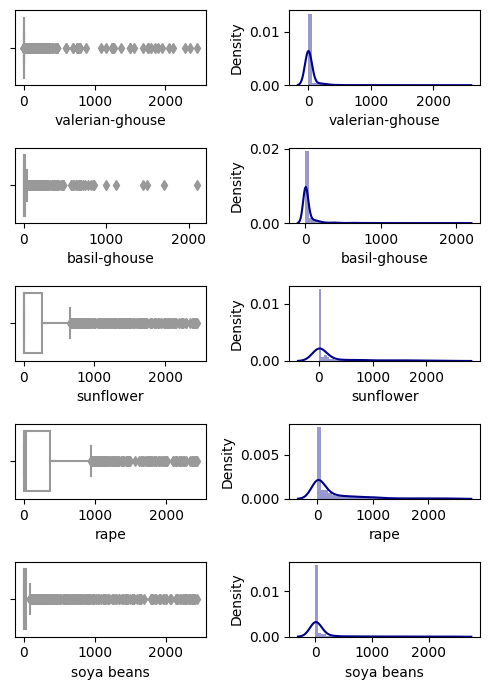

In [37]:
fig, ax = plt.subplots(5, 2, figsize = (5, 7))
sns.boxplot(x= industrial_crop_top10_pivot_stats["valerian-ghouse"], color = 'white', ax = ax[0,0])
sns.distplot(industrial_crop_top10_pivot_stats['valerian-ghouse'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["basil-ghouse"],color = 'white', ax = ax[1,0])
sns.distplot(industrial_crop_top10_pivot_stats['basil-ghouse'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["sunflower"],color = 'white', ax = ax[2,0])
sns.distplot(industrial_crop_top10_pivot_stats['sunflower'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["rape"], color = 'white', ax = ax[3,0])
sns.distplot(industrial_crop_top10_pivot_stats['rape'], color = 'darkblue', ax = ax[3,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["soya beans"], color = 'white',ax = ax[4,0])
sns.distplot(industrial_crop_top10_pivot_stats['soya beans'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

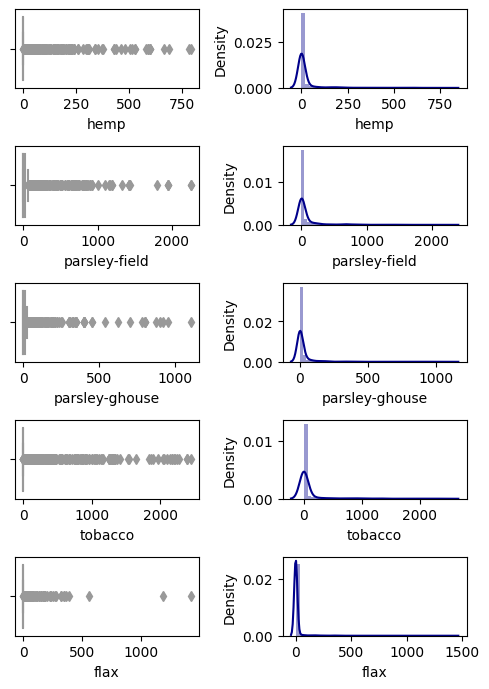

In [38]:
fig, ax = plt.subplots(5, 2, figsize = (5, 7))
sns.boxplot(x= industrial_crop_top10_pivot_stats["hemp"], color = 'white', ax = ax[0,0])
sns.distplot(industrial_crop_top10_pivot_stats['hemp'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["parsley-field"],color = 'white', ax = ax[1,0])
sns.distplot(industrial_crop_top10_pivot_stats['parsley-field'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["parsley-ghouse"],color = 'white', ax = ax[2,0])
sns.distplot(industrial_crop_top10_pivot_stats['parsley-ghouse'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["tobacco"], color = 'white',ax = ax[3,0])
sns.distplot(industrial_crop_top10_pivot_stats['tobacco'], color = 'darkblue',ax = ax[3,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["flax"], color = 'white',ax = ax[4,0])
sns.distplot(industrial_crop_top10_pivot_stats['flax'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

## Pre-processing ferlizers dataset

fertilizers distributed - tonnes


In [39]:
fertilizer = pd.read_csv('fertilizer_by_prov.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2006,2006,1227,NaN,NaN
1,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2007,2007,1812,NaN,NaN
2,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2008,2008,5224,NaN,NaN
3,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2009,2009,2051,NaN,NaN
4,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2010,2010,54,NaN,NaN


In [40]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [41]:
#fertilizer.Territory.unique()

In [42]:
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [43]:
#convert quintals to tonnes
fertilizer.loc[fertilizer['Data_type'] == 'fertilizers distributed - quintals','Fertilizers_tonnes' ] = fertilizer['Fertilizers_tonnes'] / 10


In [44]:
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,122.7
1,Torino,calcium cyanamide,2007,181.2
2,Torino,calcium cyanamide,2008,522.4
3,Torino,calcium cyanamide,2009,205.1
4,Torino,calcium cyanamide,2010,5.4
...,...,...,...,...
68381,Sud Sardegna,specific action products -,2017,335.0
68382,Sud Sardegna,specific action products -,2018,137.0
68383,Sud Sardegna,specific action products -,2019,164.0
68384,Sud Sardegna,specific action products -,2020,135.0


In [45]:
fertilizer.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrates ', 'ammonium sulphate', 'urea',
       'other fertilizers different from calcium cyanamide, nitrates, ammonium sulphate, urea',
       'simple superphosphate', 'triple superphosphate',
       'other fertilizers different from simple superphosphate and triple superphosphate',
       'sulphate', 'chloride ',
       'other fertilizers different from sulphate and chloride ',
       'two components - nitrogen-phosphorous',
       'two components - phosphorus-potassium',
       'two components - nitrogen-potassium',
       'three components - nitrogen-phosphorous-phosphorous',
       'containing only one secondary macronutrient - calcium oxide',
       'containing only one secondary macronutrient - magnesium oxide',
       'containing only one secondary macronutrient - sulphur oxide',
       'containing only one secondary macronutrient',
       'containing micronutrients containing only a micronutrient in mineral form',
       'containing micronutrients 

In [46]:
fertilizer.Year.unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021])

### Selecting fertilizers for future analysis 

In [47]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())
print(fertilizer.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               3497
three components - nitrogen-phosphorous-phosphorous                                      1941
containing only one secondary macronutrient - magnesium oxide                            1749
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
peaty soil amendment                                                                     1749
mixed soil amendment                                                                     1749
vegetable soil amendment                                                                 1749
organic-mineral fertilizers - compound                                                   1749
organic-mineral fertilizers - straight nitrogen                                          1749
organic fertilizers - compound     

In [48]:
# Rename name of fertilizers 
fertilizer = fertilizer.replace('organic fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - compound','organic-mineral')
fertilizer = fertilizer.replace('organic fertilizers - compound','organic')
fertilizer = fertilizer.replace('mixed soil amendment','mix-amend')
fertilizer = fertilizer.replace('peaty soil amendment','peaty-amend')
fertilizer = fertilizer.replace('peaty amendment','peaty-amend')
fertilizer = fertilizer.replace('peat amendment','peaty-amend')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - nitrogen-potassium','nitrogen-potassium')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - phosphorus-potassium','phosphorus-potassium')
fertilizer = fertilizer.replace('vegetable soil amendment', 'organic')

In [49]:
fertilizer = fertilizer.apply(lambda row: row[fertilizer['Type_fertilizer'].isin(['organic','nitrogen-potassium',
                                                                                  'nitrogen-phosphorous'])])

fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
88,Torino,nitrogen-phosphorous,2006,13448.7
89,Torino,nitrogen-phosphorous,2007,15689.3
90,Torino,nitrogen-phosphorous,2008,8672.4
91,Torino,nitrogen-phosphorous,2009,7766.9
92,Torino,nitrogen-phosphorous,2010,9253.3


In [50]:
fertilizer.max()

City                  Viterbo
Type_fertilizer       organic
Year                     2021
Fertilizers_tonnes    98671.6
dtype: object

In [51]:
fertilizer.describe()

,Year,Fertilizers_tonnes
count,6996.000000,6996.000000
mean,2013.493997,1539.149743
std,4.587903,3587.481455
min,2006.000000,0.000000
25%,2010.000000,45.975000
50%,2013.000000,371.000000
75%,2017.000000,1544.625000
max,2021.000000,98671.600000


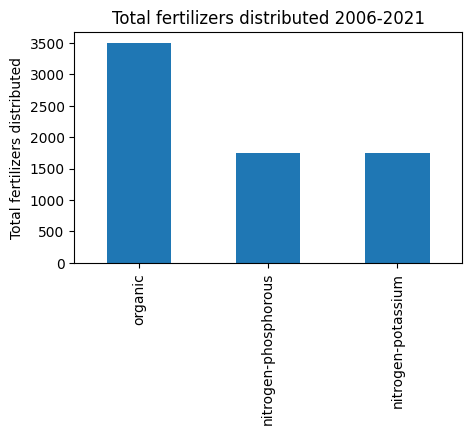

In [52]:
plt.figure(figsize=(5,3))
fertilizer['Type_fertilizer'].value_counts().plot.bar()
plt.title('Total fertilizers distributed 2006-2021')
plt.ylabel('Total fertilizers distributed')
plt.show()

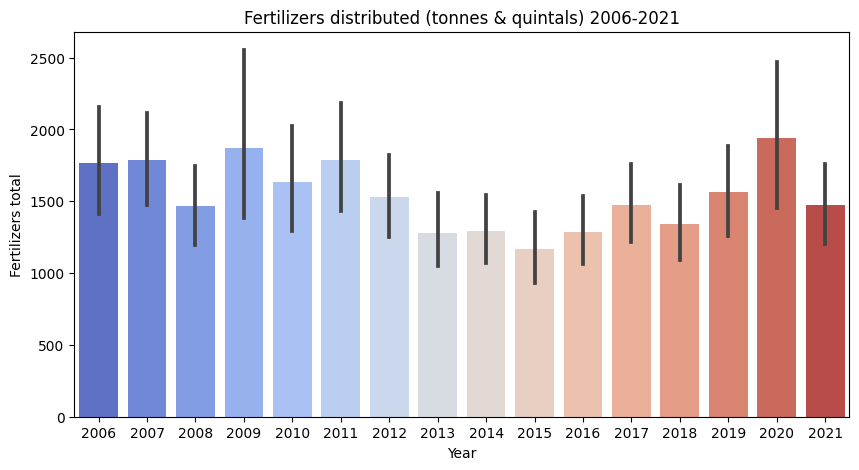

In [53]:
# fertilizer distributed tonnes and quintals
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Fertilizers_tonnes',data = fertilizer, palette='coolwarm')
plt.title('Fertilizers distributed (tonnes & quintals) 2006-2021')
plt.xlabel('Year')
plt.ylabel('Fertilizers total')
plt.show()


In [54]:
fertilizer30 = fertilizer.nlargest(30, 'Fertilizers_tonnes')

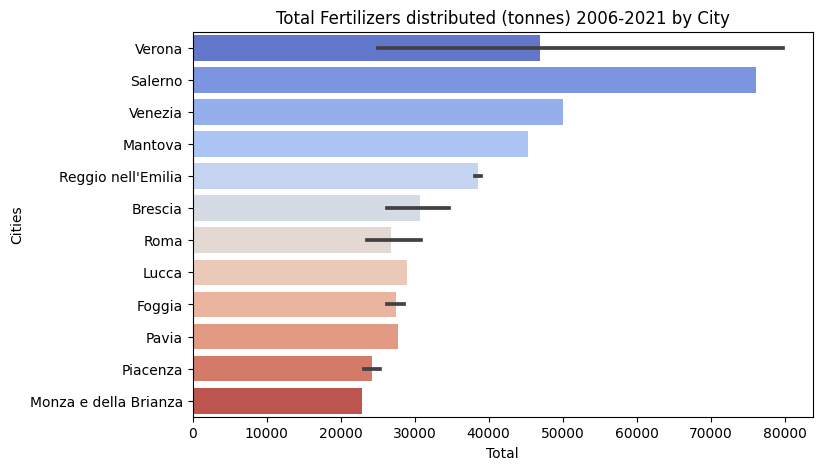

In [55]:
fertilizer= fertilizer.sort_values('Fertilizers_tonnes',ascending=False)

plt.figure(figsize= (8,5))
sns.barplot(x=fertilizer30['Fertilizers_tonnes'] ,y= fertilizer30 ['City'], palette='coolwarm');
plt.title('Total Fertilizers distributed (tonnes) 2006-2021 by City')
plt.xlabel('Total')
plt.ylabel('Cities')
plt.show()

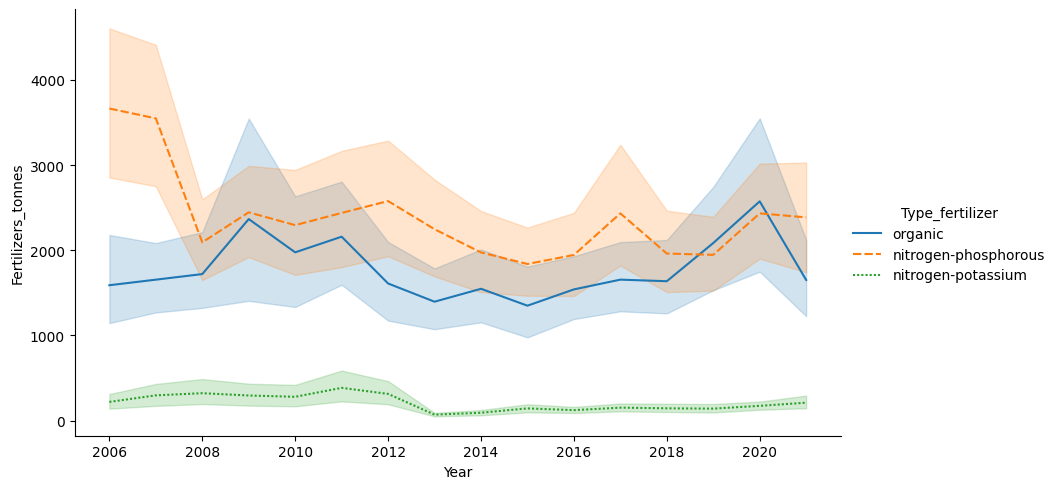

In [56]:
#Fertilizers distributed by year

fertilizer_plot = sns.relplot(kind='line', data=fertilizer, x='Year', y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)


In [57]:
fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
8734,Verona,organic,2009,98671.6
35036,Salerno,organic,2020,76184.0
9983,Venezia,organic,2010,50055.6
7390,Mantova,organic,2009,45375.2
8731,Verona,organic,2006,39235.9


### Create new dataframe with the selected type of fertilizers as columns

In [58]:
# Create columns for each type of fertilizer 
fertilizer_pivot = fertilizer.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer_pivot

Fertilizers_tonnes                           
Type_fertilizer nitrogen-phosphorous nitrogen-potassium organic
City      Year                                                 
Agrigento 2006                 497.7               27.7  3143.9
          2007                 649.8               49.1  3534.8
          2008                 521.3               61.4  3750.4
          2009                 380.8               46.8  2791.4
          2010                 327.1               44.0  2346.0
...                              ...                ...     ...
Viterbo   2017                4732.0               66.0  1760.0
          2018                4376.0               19.0  1591.0
          2019                3964.0              195.0  1251.0
          2020                6145.0               98.0  1236.0
          2021                3946.0              112.0  1056.0

[1749 rows x 3 columns]

In [59]:
# Drop level
fertilizer_pivot.columns = fertilizer_pivot.columns.droplevel()
fertilizer_pivot

Type_fertilizer  nitrogen-phosphorous  nitrogen-potassium  organic
City      Year                                                    
Agrigento 2006                  497.7                27.7   3143.9
          2007                  649.8                49.1   3534.8
          2008                  521.3                61.4   3750.4
          2009                  380.8                46.8   2791.4
          2010                  327.1                44.0   2346.0
...                               ...                 ...      ...
Viterbo   2017                 4732.0                66.0   1760.0
          2018                 4376.0                19.0   1591.0
          2019                 3964.0               195.0   1251.0
          2020                 6145.0                98.0   1236.0
          2021                 3946.0               112.0   1056.0

[1749 rows x 3 columns]

In [60]:
#Rename index
fertilizer_pivot = fertilizer_pivot.rename_axis(None,axis=1)
fertilizer_pivot

nitrogen-phosphorous  nitrogen-potassium  organic
City      Year                                                   
Agrigento 2006                 497.7                27.7   3143.9
          2007                 649.8                49.1   3534.8
          2008                 521.3                61.4   3750.4
          2009                 380.8                46.8   2791.4
          2010                 327.1                44.0   2346.0
...                              ...                 ...      ...
Viterbo   2017                4732.0                66.0   1760.0
          2018                4376.0                19.0   1591.0
          2019                3964.0               195.0   1251.0
          2020                6145.0                98.0   1236.0
          2021                3946.0               112.0   1056.0

[1749 rows x 3 columns]

In [61]:
# Reset index
fertilizer_pivot = fertilizer_pivot.reset_index()
fertilizer_pivot

,City,Year,nitrogen-phosphorous,nitrogen-potassium,organic
0,Agrigento,2006,497.7,27.7,3143.9
1,Agrigento,2007,649.8,49.1,3534.8
2,Agrigento,2008,521.3,61.4,3750.4
3,Agrigento,2009,380.8,46.8,2791.4
4,Agrigento,2010,327.1,44.0,2346.0
...,...,...,...,...,...
1744,Viterbo,2017,4732.0,66.0,1760.0
1745,Viterbo,2018,4376.0,19.0,1591.0
1746,Viterbo,2019,3964.0,195.0,1251.0
1747,Viterbo,2020,6145.0,98.0,1236.0


#### Join crop and fertilizers datasets

In [62]:
# Join both datasets 
it_crop_ferlizer = pd.merge(industrial_crop_top10_pivot, fertilizer_pivot, on=['City','Year'], how='left').fillna(0)
it_crop_ferlizer

,City,Year,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,tobacco,valerian-ghouse,nitrogen-phosphorous,nitrogen-potassium,organic
0,Agrigento,2006,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,497.7,27.7,3143.9
1,Agrigento,2007,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,649.8,49.1,3534.8
2,Agrigento,2008,0.0,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,0.0,521.3,61.4,3750.4
3,Agrigento,2009,0.0,0.0,0.0,8.4,0.0,0.0,0.0,0.0,0.0,0.0,380.8,46.8,2791.4
4,Agrigento,2010,0.0,0.0,0.0,9.7,0.0,0.0,0.0,0.0,0.0,0.0,327.1,44.0,2346.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,Viterbo,2016,0.0,0.0,0.0,0.0,0.0,378.0,0.0,1680.0,770.2,0.0,5360.0,41.0,1613.0
1430,Viterbo,2017,0.0,0.0,0.0,0.0,0.0,370.0,0.0,1670.0,859.2,0.0,4732.0,66.0,1760.0
1431,Viterbo,2018,0.0,100.0,48.0,0.0,0.0,42.0,0.0,1800.0,635.2,0.0,4376.0,19.0,1591.0
1432,Viterbo,2019,0.0,115.0,16.5,0.0,0.0,60.0,0.0,1800.0,750.0,0.0,3964.0,195.0,1251.0


### Correlation

In [63]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer[['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                                  'soya beans', 'hemp', 'parsley-field','parsley-ghouse',
                                  'tobacco', 'flax','organic','nitrogen-potassium',
                                     'nitrogen-phosphorous']] 


<AxesSubplot: title={'center': 'Correlation'}>

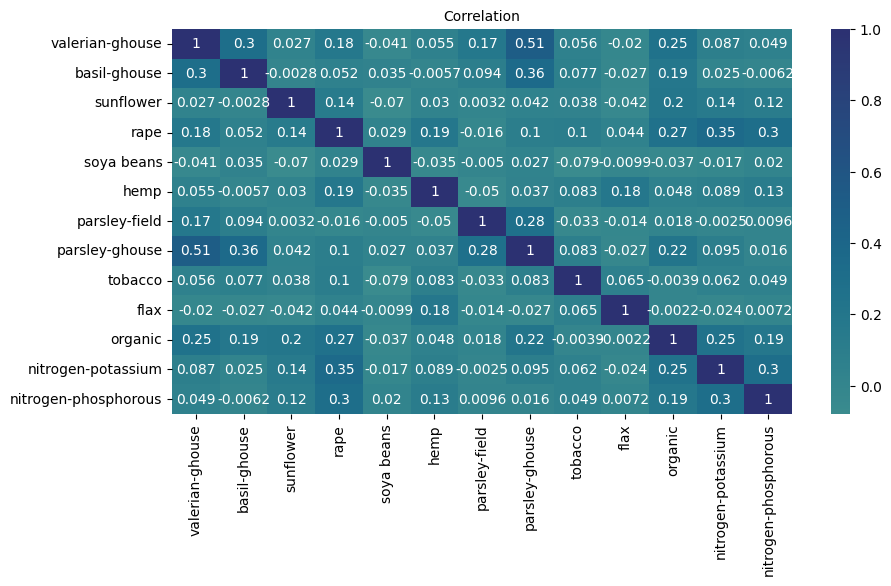

In [64]:
plt.figure(figsize=(10,5))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of industrial crop production in Italy 

* Valerian in the greenhouse has high correlation with parsley in the greenhouse. 


### Calculating Variance Inflation Factor (VIF) for all given features

In [65]:
# Function to compute the VIF
def compute_vif(selected_features):
    
    y = cor_selected [selected_features]
    # the calculation of variance inflation requires a constant
    y['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Feature"] = y.columns
    vif["VIF"] = [variance_inflation_factor(y.values, i) for i in range(y.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [66]:
# Features selection
selected_features = ['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                      'soya beans', 'hemp', 'parsley-field','parsley-ghouse',
                      'tobacco', 'flax', 'organic','nitrogen-potassium',
                                     'nitrogen-phosphorous']

# compute vif 
compute_vif(selected_features).sort_values('VIF', ascending=False)


,Feature,VIF
7,parsley-ghouse,1.538816
0,valerian-ghouse,1.442561
3,rape,1.296665
10,organic,1.238696
11,nitrogen-potassium,1.233162
1,basil-ghouse,1.195313
12,nitrogen-phosphorous,1.178896
6,parsley-field,1.097456
5,hemp,1.087112
2,sunflower,1.068746


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html